In [3]:
from rllib.mdp import OptimalGoalPolicy
from rllib.shapeworld import GoalWorld
from sklearn.manifold import MDS
from itertools import combinations, product
import numpy as np
import pandas as pd
import random
from random import sample
from random import Random
from math import log
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
from typing import Sequence, Hashable, TypeVar, Generic, Tuple
import pickle
from rllib.mdp import MarkovDecisionProcess
from tqdm import tqdm
from dataclasses import dataclass
from pydantic.dataclasses import dataclass
from typing import Literal
import dataclasses
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## State and Action Definitions

In [4]:
# Define generic type variables for any state/action types
S = TypeVar('S', bound=Hashable)  # Generic State type
A = TypeVar('A', bound=Hashable)  # Generic Action type

@dataclass(frozen=True)
class Shape:
    sides: Literal['circle', 'square', 'triangle']
    shade: Literal['low', 'medium', 'high']
    texture: Literal['plain', 'stripes', 'dots']

    def __eq__(self, other) -> bool:
        """Compare two shapes for equality.
        
        Shapes are equal if all their attributes match.
        
        Args:
            other: Another Shape object to compare with
            
        Returns:
            bool: True if shapes are equal, False otherwise
        """
        if not isinstance(other, Shape):
            return False
        
        return (self.sides == other.sides and 
                self.shade == other.shade and 
                self.texture == other.texture)
    
    def __hash__(self):
        """Make Shape hashable for use as dictionary key.
        
        Returns:
            int: Hash value based on the attributes
        """
        return hash((self.sides, self.shade, self.texture))

    def __post_init__(self):
        # Additional validation if needed
        if self.sides not in ['circle', 'square', 'triangle']:
            raise ValueError(f'Invalid shape: {self.sides}')
        if self.shade not in ['low', 'medium', 'high']:
            raise ValueError(f'Invalid shade: {self.shade}')
        if self.texture not in ['plain', 'stripes', 'dots']:
            raise ValueError(f'Invalid texture: {self.texture}')

@dataclass(frozen=True)
class State:
    shape1: Shape
    shape2: Shape
    shape3: Shape

    def __eq__(self, other) -> bool:
        """Compare two states for equality.
        
        States are equal if all their shapes are equal in corresponding positions.
        
        Args:
            other: Another State object to compare with
            
        Returns:
            bool: True if states are equal, False otherwise
        """
        if not isinstance(other, State):
            return False
        
        return (self.shape1 == other.shape1 and 
                self.shape2 == other.shape2 and 
                self.shape3 == other.shape3)
    
    def __hash__(self):
        """Make State hashable for use as dictionary key.
        
        Returns:
            int: Hash value based on the shapes
        """
        return hash((self.shape1, self.shape2, self.shape3))

@dataclass(frozen=True)
class Action:
    actor: Literal[1, 2, 3]
    recipient: Literal[1, 2, 3]
    
    def __post_init__(self):
        if self.actor == self.recipient:
            raise ValueError("Actor and recipient must be different")
        if not (1 <= self.actor <= 3 and 1 <= self.recipient <= 3):
            raise ValueError("Actor and recipient must be between 1 and 3")
        
class Likelihood:
    def __init__(self, value: float):
        if not 0 <= value <= 1:
            raise ValueError(f"Likelihood must be between 0 and 1, got {value}")
        self._value = value
    
    def __float__(self):
        return self._value
    
    def __repr__(self):
        return f"Likelihood({self._value})"

In [8]:

class GoalSelectionPolicy(MarkovDecisionProcess[State, Action]):
    def __init__(self, mdp: MarkovDecisionProcess[State, Action]):
        '''Initialize the policy with the MDP.'''
        self.mdp = mdp
        self.state_space = mdp.state_space

    def sample_action(self, rng : Random = random) -> tuple[Action, Likelihood]:
        '''Uses some policy to select which goal to select.'''
        raise NotImplementedError

    def reset(self):
        raise NotImplementedError

class OptimalGoalPolicy(MarkovDecisionProcess[State, Action]):
    '''Takes the optimal value function computed from value iteration to select goals.'''

    def __init__(self, mdp: MarkovDecisionProcess[State, Action], value_function: dict[State, float]):
        super().__init__(mdp)
        # we will use the value function from value iteration to select the goal
        self.value_function = value_function
        # TO DO: Remove multi-dimensional scaling.
        self.mds = None # multidimensional scaling

    def sample_action(self, rng: random.Random = random) -> tuple[State, float]:
        '''Use softmax to sample a goal state based on the value function.'''
        # Assuming 'actions' here are actually states for goal selection
        states = list(self.value_function.keys())
        state_values = np.array([self.value_function[state] for state in states])

        # Compute softmax probabilities
        exp_values = np.exp(state_values - np.max(state_values))  # for numerical stability
        probabilities = exp_values / np.sum(exp_values)

        # Sample a state based on these probabilities
        selected_state = rng.choices(states, weights=probabilities)[0]

        # Calculate the negative log likelihood of the selected state
        nll = -np.log(probabilities[states.index(selected_state)])

        return (selected_state, nll)
    
    def calc_neg_log_lik(self, state: State) -> float:
        '''Calculate the negative log likelihood of selecting a particular state.

        Parameters:
        state (State): The state for which to calculate the negative log likelihood.

        Returns:
        float: The negative log likelihood of selecting the given state.
        '''
        state_values = np.array([self.value_function[s] for s in self.state_space])
        exp_values = np.exp(state_values - np.max(state_values))
        probabilities = exp_values / np.sum(exp_values)
        return -np.log(probabilities[self.state_space.index(state)])
    
    def calc_neg_log_likelihood_all(self) -> dict[State, float]:
        '''Calculate the log likelihood of all states in the state space.'''
        # get all the value for the states and convert them to probabilities
        state_values = np.array([self.value_function[state] for state in self.state_space])
        exp_values = np.exp(state_values - np.max(state_values))
        probabilities = exp_values / np.sum(exp_values)
        # print(f"Length of probabilities: {len(probabilities)}")
        neg_log_likelihoods = {s: -np.log(probabilities[self.state_space.index(s)]) for s in self.state_space}
        return neg_log_likelihoods
    
    def calc_neg_log_likelihood_all_df(self) -> pd.DataFrame:
        '''Return log lik as a dataframe.'''
        neg_log_likelihood = self.calc_neg_log_likelihood_all()
        return pd.DataFrame(neg_log_likelihood.items(), columns=['State', 'Negative Log Lik'])
    
    def _load_value_functions_all(self, directory):
        """
        Load all value function files from the specified directory.
        
        Note, this is not the same as the value function for choosing goals. 
        These are the results of value iteration for separate goal state.
        This is intended to be used for calculated a distance matrix between states.
        """
        print('Loading value functions from directory:', directory)
        value_functions = {}
        for filename in tqdm(os.listdir(directory), desc='Loading files'):
            if filename.endswith('.pkl'):
                filepath = os.path.join(directory, filename)
                with open(filepath, 'rb') as file:
                    value_function, goal_state = pd.read_pickle(file)
                    adjusted_value_function = {state: value - self.mdp.GOAL_REWARD for state, value in value_function.items()}
                    value_functions[goal_state] = adjusted_value_function
        return value_functions

    def _calc_distance_matrix(self) -> np.ndarray:
        '''Calculate the distance matrix between all states in the state space.'''

        val_funs = self._load_value_functions_all('value-iteration-results')

        # Extract all unique states from the keys of the value functions
        print('Sorting states...')
        states = list(set.union(*[set(vf.keys()) for vf in val_funs.values()]))
        states.sort()  # Ensure consistent order
        num_states = len(states)

        # Initialize the distance matrix with infinity
        distance_matrix = np.full((num_states, num_states), np.inf)

        # Fill in the distance matrix
        for i, state_i in tqdm(enumerate(states), total=len(states), desc="Computing distance matrix"):
            for j, state_j in enumerate(states):
                if state_i in val_funs and state_j in val_funs[state_i]:
                    value = val_funs[state_i][state_j]
                    # larger negative means further from goal, thus abs()
                    distance_matrix[i, j] = abs(value) if value != 0 else np.inf
                    # Goals states have a distance of 0
                    if state_j == state_i:
                        distance_matrix[i, j] = 0

        # Our distance is not symmetric since there are some state transitions that are asymetric
        for i in tqdm(range(num_states), desc="Ensuring symmetry"):
            for j in range(i+1, num_states):  # Only iterate over the upper triangle, excluding the diagonal
                # Take the minimum distance as our measure of similarity
                min_distance = min(abs(distance_matrix[i, j]), abs(distance_matrix[j, i]))
                # Update both entries to ensure symmetry
                distance_matrix[i, j] = distance_matrix[j, i] = min_distance
        return distance_matrix

    def calc_multi_dimensional_scaling(self) -> np.ndarray:
        distance_matrix = self._calc_distance_matrix()
        # Apply MDS
        print('Applying Multi-Dimensional Scaling...')
        mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
        coords = mds.fit_transform(distance_matrix)
        self.mds = coords

    def plot_state_space(self):
        '''Plot the state space in 2D using MDS.'''
        if self.mds is None:
            self.calc_multi_dimensional_scaling()

        plt.figure(figsize=(10, 8))
        plt.scatter(self.mds[:, 0], self.mds[:, 1], marker='o')
        for i, coord in enumerate(self.mds):
            plt.text(coord[0], coord[1], str(i), color='red')
        plt.title('ShapeWorld Visualization')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.show()

    def plot_state_space_with_likelihood(self, is_dark=False, save=False, filename=None):
        '''Plot the state space in 2D using MDS with the negative log likelihood of each state.'''
        
        # Check to see if the mds has been calculated
        if self.mds is None:
            self.calc_multi_dimensional_scaling()

        # Calculate the negative log likelihood of each state
        neg_log_likelihoods = self.calc_neg_log_likelihood_all_df()


        # Set the font properties
        font_path = os.path.abspath('/System/Library/Fonts/HelveticaNeue.ttc')  # Replace with the path to your desired font file
        font_prop = fm.FontProperties(fname=font_path, size=14)

        # set deafult style
        matplotlib.rcdefaults()

        plt.figure(figsize=(10, 8))
        # Sort the coordinates and likelihoods in descending order based on likelihoods
        sorted_indices = np.argsort(neg_log_likelihoods['Negative Log Lik'])[::-1]
        #print(sorted_indices)
        sorted_coords = self.mds[sorted_indices]
        # print(sorted_coords)
        sorted_likelihoods = np.array(neg_log_likelihoods['Negative Log Lik'])[sorted_indices]
        print(sorted_likelihoods)
        # Plot the points with greater likelihoods on top
        plt.scatter(sorted_coords[:, 0], sorted_coords[:, 1], c=sorted_likelihoods, cmap='plasma_r', marker='o', alpha=1, s=70)
        plt.title('ShapeWorld 2D Embedding by Distance: Optimal Planner', fontsize=15)
        plt.xlabel('Dimension 1', fontproperties=font_prop, fontsize=16)  # Set the font properties for x-axis label
        plt.ylabel('Dimension 2', fontproperties=font_prop, fontsize=16)  # Set the font properties for y-axis label
        plt.colorbar(label='Negative Log Lik')
        plt.grid(False)  # Remove gridlines

        plt.xticks([])  # Remove x-axis tick labels
        plt.yticks([])  # Remove y-axis tick labels
        plt.tight_layout()  # Adjust spacing
        plt.show()

        if save:
            plt.savefig(filename)

    def plot_state_space_with_other_model_likelihood_df(self, negloglik: pd.DataFrame, model_name, is_dark=False, save=False, filename=None):
        '''Plot the state space in 2D using MDS with the negative log likelihood from another model.'''

       # Check to see if the mds has been calculated
        if self.mds is None:
            self.calc_multi_dimensional_scaling()

        # Calculate the negative log likelihood of each state
        neg_log_likelihoods = negloglik


        # Set the font properties
        font_path = os.path.abspath('/System/Library/Fonts/HelveticaNeue.ttc')  # Replace with the path to your desired font file
        font_prop = fm.FontProperties(fname=font_path, size=14)

        # set deafult style
        matplotlib.rcdefaults()

        plt.figure(figsize=(10, 8))
        # Sort the coordinates and likelihoods in descending order based on likelihoods
        sorted_indices = np.argsort(neg_log_likelihoods['Negative Log Lik'])[::-1]
        #print(sorted_indices)
        sorted_coords = self.mds[sorted_indices]
        # print(sorted_coords)
        sorted_likelihoods = np.array(neg_log_likelihoods['Negative Log Lik'])[sorted_indices]
        print(sorted_likelihoods)
        # Plot the points with greater likelihoods on top
        plt.scatter(sorted_coords[:, 0], sorted_coords[:, 1], c=sorted_likelihoods, cmap='plasma_r', marker='o', alpha=1, s=70)
        plt.title('ShapeWorld 2D Embedding by Distance: Optimal Planner', fontsize=15)
        plt.xlabel('Dimension 1', fontproperties=font_prop, fontsize=16)  # Set the font properties for x-axis label
        plt.ylabel('Dimension 2', fontproperties=font_prop, fontsize=16)  # Set the font properties for y-axis label
        plt.colorbar(label='Negative Log Lik')
        plt.grid(False)  # Remove gridlines

        plt.xticks([])  # Remove x-axis tick labels
        plt.yticks([])  # Remove y-axis tick labels
        plt.tight_layout()  # Adjust spacing
        plt.show()

    def reset(self):
        pass

class ShapeWorld(MarkovDecisionProcess[State, Action]):
    GOAL = None
    DISCOUNT_RATE = None
    GOAL_REWARD = 0 # we let this be zero because of averaging across Q-tables we do later
    STEP_COST = -1
    

    # Feature space
    SHAPE_LIST = tuple(['circle','square','triangle'])
    SHADE_LIST = tuple(['low','medium','high'])
    TEXTURE_LIST = tuple(['plain','stripes','dots'])

    # Transition probabilities
    SHAPE_TRANSITION_PROB = 0.8
    TEXTURE_TRANSITION_PROB = 1.0
    SHADE_CYCLE_PROB = 0.2 # when shades are the same, 20% change to cycle around for boundary shades

    def __init__(self, goal: State, discount_rate: float):
        '''Runs the initialization of the ShapeWorld class.'''
        self.DISCOUNT_RATE = discount_rate
        self.GOAL = goal

        # set up shapeworld shape space
        shape_space: list[Shape] = [
            Shape(sides=sides, shade=shade, texture=texture)
            for sides, shade, texture in product(
                self.SHAPE_LIST,
                self.SHADE_LIST,
                self.TEXTURE_LIST
            )
        ]
            
        # set up state space
        self.state_space: list[State] = [
            State(shape1=shape1, shape2=shape2, shape3=shape3)
            for shape1, shape2, shape3 in product(shape_space, shape_space, shape_space)
        ]

        # set up action space
        self.action_space = [
            Action(actor=1, recipient=2),  # a1r2
            Action(actor=1, recipient=3),  # a1r3
            Action(actor=2, recipient=1),  # a2r1
            Action(actor=2, recipient=3),  # a2r3
            Action(actor=3, recipient=1),  # a3r1
            Action(actor=3, recipient=2),  # a3r2
        ]

    def next_state_sample(self, s: State, a: Action, rng: random.Random = random) -> State:
        '''
        Given a state and action, return a possible next state.
        
        Note on indexing:
        - Action.actor and Action.recipient are 1-based (1,2,3)
        - Python list indexing is 0-based (0,1,2)
        - State attributes are accessed by name (shape1, shape2, shape3)
        '''
        # Get shapes using proper attribute names
        actor_shape = getattr(s, f'shape{a.actor}')
        recipient_shape = getattr(s, f'shape{a.recipient}')
        
        # 1. Determine recipient's new shape
        if rng.random() < self.SHAPE_TRANSITION_PROB:
            sides = actor_shape.sides
        else:
            available_shapes = [shape for shape in self.SHAPE_LIST if shape != actor_shape.sides]
            sides = rng.choice(available_shapes)
        
        # 2. Determine recipient's new texture
        current_texture_idx = self.TEXTURE_LIST.index(recipient_shape.texture)
        next_texture_idx = (current_texture_idx + 1) % len(self.TEXTURE_LIST)
        texture = self.TEXTURE_LIST[next_texture_idx]
        
        # 3. Determine recipient's new shade
        actor_shade_idx = self.SHADE_LIST.index(actor_shape.shade)
        recipient_shade_idx = self.SHADE_LIST.index(recipient_shape.shade)
        
        if actor_shade_idx == recipient_shade_idx:
            # Same shade case
            if recipient_shape.shade in ['low', 'high']:
                if rng.random() < self.SHADE_CYCLE_PROB:
                    shade = 'high' if recipient_shape.shade == 'low' else 'low'
                else:
                    shade = recipient_shape.shade
            elif recipient_shape.shade == 'medium':
                if rng.random() < self.SHADE_CYCLE_PROB:
                    shade = rng.choice(['low', 'high'])
                else:
                    shade = 'medium'
        else:
            # Different shade case: move one step towards actor's shade
            if actor_shade_idx > recipient_shade_idx:
                shade = self.SHADE_LIST[recipient_shade_idx + 1]
            else:
                shade = self.SHADE_LIST[recipient_shade_idx - 1]
        
        # Create new state using proper attribute names
        new_shapes = {
            'shape1': s.shape1,
            'shape2': s.shape2,
            'shape3': s.shape3
        }
        new_shapes[f'shape{a.recipient}'] = Shape(sides=sides, shade=shade, texture=texture)
        
        return State(
            shape1=new_shapes['shape1'],
            shape2=new_shapes['shape2'],
            shape3=new_shapes['shape3']
        )

    def reward(self, s: State, a: Action, ns: State) -> float:
        """Calculate the reward for a state transition.
        
        Args:
            s: Current state
            a: Action taken
            ns: Next state
        
        Returns:
            float: STEP_COST (-1) for each action, plus GOAL_REWARD (0) if goal reached
        
        Note:
            GOAL_REWARD is 0 because we average across Q-tables later.
            This means the reward structure is purely driven by path length to goal.
        """
        reward = self.STEP_COST
        if self._is_goal(ns):
            reward += self.GOAL_REWARD
        return reward

    def is_absorbing(self, s: State) -> bool:
        '''
        Check to see if state is absorbing. 

        For this context, the goal state is our absorbing state, and the simulation 
        should be terminated if reached.

        Args:
            s: The state to check

        Returns:
            bool: Whether the state is an absorbing state (goal state) or not.
        '''
        return self.GOAL == s

    def get_possible_next_states(self, s: State, a: Action) -> Sequence[State]:
        """Return the possible next states given a state and action.
        
        Args:
            s: Current state
            a: Action taken
            
        Returns:
            Sequence[State]: List of all possible next states
        """
        # Get shapes using proper attribute names
        actor_shape = getattr(s, f'shape{a.actor}')
        recipient_shape = getattr(s, f'shape{a.recipient}')
        
        # 1. Determine possible sides (80% actor's shape, 20% different shape)
        possible_sides = [actor_shape.sides]  # 80% chance
        other_sides = [side for side in self.SHAPE_LIST if side != actor_shape.sides]
        possible_sides.extend(other_sides)  # 20% chance split among other shapes
        
        # 2. Determine possible shades
        if actor_shape.shade == recipient_shape.shade:
            # Same shade case
            if recipient_shape.shade in ['low', 'high']:
                possible_shades = [
                    recipient_shape.shade,  # 80% chance stay same
                    'high' if recipient_shape.shade == 'low' else 'low'  # 20% chance to flip
                ]
            elif recipient_shape.shade == 'medium':
                possible_shades = [
                    'medium',  # 80% chance stay same
                    'low',    # 10% chance
                    'high'    # 10% chance
                ]
        else:
            # Different shade case - move one step towards actor's shade
            recipient_idx = self.SHADE_LIST.index(recipient_shape.shade)
            actor_idx = self.SHADE_LIST.index(actor_shape.shade)
            step = 1 if actor_idx > recipient_idx else -1
            possible_shades = [self.SHADE_LIST[recipient_idx + step]]
        
        # 3. Determine possible textures (cycles through plain -> stripes -> dots)
        current_texture_idx = self.TEXTURE_LIST.index(recipient_shape.texture)
        next_texture_idx = (current_texture_idx + 1) % len(self.TEXTURE_LIST)
        possible_textures = [self.TEXTURE_LIST[next_texture_idx]]
        
        # Generate all possible combinations
        possible_states = set()
        for sides in possible_sides:
            for shade in possible_shades:
                for texture in possible_textures:
                    # Create new shape with the combination
                    new_shape = Shape(sides=sides, shade=shade, texture=texture)
                    
                    # Create new state, only updating the recipient shape
                    if a.recipient == 1:
                        new_state = State(shape1=new_shape, shape2=s.shape2, shape3=s.shape3)
                    elif a.recipient == 2:
                        new_state = State(shape1=s.shape1, shape2=new_shape, shape3=s.shape3)
                    else:  # recipient == 3
                        new_state = State(shape1=s.shape1, shape2=s.shape2, shape3=new_shape)
                    
                    possible_states.add(new_state)
        
        return list(possible_states)
    
    def transition_probability(self, s: State, a: Action, ns: State) -> float:
        """Return the transition probability from state s to state ns given action a.
        
        Args:
            s: Current state
            a: Action taken
            ns: Next state
            
        Returns:
            float: Probability of transitioning from s to ns given action a
        """
        # Get shapes using proper attribute access
        actor_shape = getattr(s, f'shape{a.actor}')
        recipient_shape = getattr(s, f'shape{a.recipient}')
        next_recipient_shape = getattr(ns, f'shape{a.recipient}')
        
        # Verify that only the recipient shape changed
        if (getattr(ns, f'shape{a.actor}') != actor_shape or
            any(getattr(ns, f'shape{i}') != getattr(s, f'shape{i}') 
                for i in [1,2,3] if i != a.recipient)):
            return 0.0
        
        # 1. Check shape transition
        shape_prob = 0.0
        if next_recipient_shape.sides == actor_shape.sides:
            shape_prob = self.SHAPE_TRANSITION_PROB
        elif next_recipient_shape.sides != actor_shape.sides:
            available_shapes = [shape for shape in self.SHAPE_LIST if shape != actor_shape.sides]
            shape_prob = (1 - self.SHAPE_TRANSITION_PROB) / len(available_shapes)
        else:
            return 0.0

        # 2. Check texture transition
        texture_prob = 0.0
        current_texture_idx = self.TEXTURE_LIST.index(recipient_shape.texture)
        expected_texture_idx = (current_texture_idx + 1) % len(self.TEXTURE_LIST)
        if next_recipient_shape.texture == self.TEXTURE_LIST[expected_texture_idx]:
            texture_prob = 1.0
        else:
            return 0.0

        # 3. Check shade transition
        shade_prob = 0.0
        if actor_shape.shade == recipient_shape.shade:
            # Same shade case
            if recipient_shape.shade in ['low', 'high']:
                if next_recipient_shape.shade == recipient_shape.shade:
                    shade_prob = 1 - self.SHADE_CYCLE_PROB
                elif (recipient_shape.shade == 'low' and next_recipient_shape.shade == 'high' or
                    recipient_shape.shade == 'high' and next_recipient_shape.shade == 'low'):
                    shade_prob = self.SHADE_CYCLE_PROB
            elif recipient_shape.shade == 'medium':
                if next_recipient_shape.shade == 'medium':
                    shade_prob = 1 - self.SHADE_CYCLE_PROB
                elif next_recipient_shape.shade in ['low', 'high']:
                    shade_prob = self.SHADE_CYCLE_PROB / 2  # Equal chance of low or high
        else:
            # Different shade case - move one step towards actor's shade
            recipient_idx = self.SHADE_LIST.index(recipient_shape.shade)
            actor_idx = self.SHADE_LIST.index(actor_shape.shade)
            step = 1 if actor_idx > recipient_idx else -1
            if next_recipient_shape.shade == self.SHADE_LIST[recipient_idx + step]:
                shade_prob = 1.0

        # Return combined probability
        return shape_prob * texture_prob * shade_prob

    def plot_state_transitions(self, state: State, action: Action, n_samples: int = 10000):
        """Visualize state transitions from a given state and action.
        
        Args:
            state: Starting state
            action: Action to take
            n_samples: Number of samples to generate
        """
        
        # Get all possible next states and their theoretical probabilities
        possible_states = self.get_possible_next_states(state, action)
        theoretical_probs = {
            ns: self.transition_probability(state, action, ns)
            for ns in possible_states
        }
        
        # Generate samples
        samples = [self.next_state_sample(state, action) for _ in range(n_samples)]
        empirical_counts = Counter(samples)
        empirical_probs = {s: c/n_samples for s, c in empirical_counts.items()}
        
        # Create figure with subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Compare theoretical vs empirical probabilities
        states = list(set(possible_states) | set(empirical_counts.keys()))
        x = range(len(states))
        theoretical = [theoretical_probs.get(s, 0) for s in states]
        empirical = [empirical_probs.get(s, 0) for s in states]
        
        width = 0.35
        ax1.bar([i - width/2 for i in x], theoretical, width, label='Theoretical', alpha=0.6)
        ax1.bar([i + width/2 for i in x], empirical, width, label='Empirical', alpha=0.6)
        ax1.set_ylabel('Probability')
        ax1.set_title('Transition Probabilities')
        ax1.legend()
        
        # Plot 2: Feature changes
        feature_changes = {
            'sides': 0,
            'shade': 0,
            'texture': 0
        }
        
        recipient_idx = action.recipient
        recipient_shape = getattr(state, f'shape{recipient_idx}')
        
        for ns in samples:
            new_recipient = getattr(ns, f'shape{recipient_idx}')
            if new_recipient.sides != recipient_shape.sides:
                feature_changes['sides'] += 1
            if new_recipient.shade != recipient_shape.shade:
                feature_changes['shade'] += 1
            if new_recipient.texture != recipient_shape.texture:
                feature_changes['texture'] += 1
        
        # Convert to percentages
        for k in feature_changes:
            feature_changes[k] = (feature_changes[k] / n_samples) * 100
        
        ax2.bar(feature_changes.keys(), feature_changes.values())
        ax2.set_ylabel('Percentage Changed (%)')
        ax2.set_title('Feature Change Frequencies')
        
        # Add percentage labels on top of bars
        for i, v in enumerate(feature_changes.values()):
            ax2.text(i, v + 1, f'{v:.1f}%', ha='center')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\nSummary of transitions:")
        print(f"Number of possible next states: {len(possible_states)}")
        print(f"Number of observed next states: {len(empirical_counts)}")
        print("\nFeature change frequencies:")
        for feature, pct in feature_changes.items():
            print(f"{feature.capitalize()}: {pct:.1f}%")

    def get_state_space(self) -> Sequence[State]:
        '''Return the state space.'''
        return self.state_space
    
    def get_actions(self, s : State) -> Sequence[Action]:
        '''Return the action space.'''
        return self.action_space

    # helper functions
    def _is_goal(self, ns : State):
        return self.GOAL == ns


### Test ShapeWorld Class

In [9]:
goal = State(shape1=Shape(sides='square', shade='low', texture='plain'), 
             shape2=Shape(sides='square', shade='low', texture='plain'), 
             shape3=Shape(sides='square', shade='low', texture='plain'))

shape_world = ShapeWorld(goal=goal, discount_rate=0.9)

len(shape_world.get_state_space())

19683

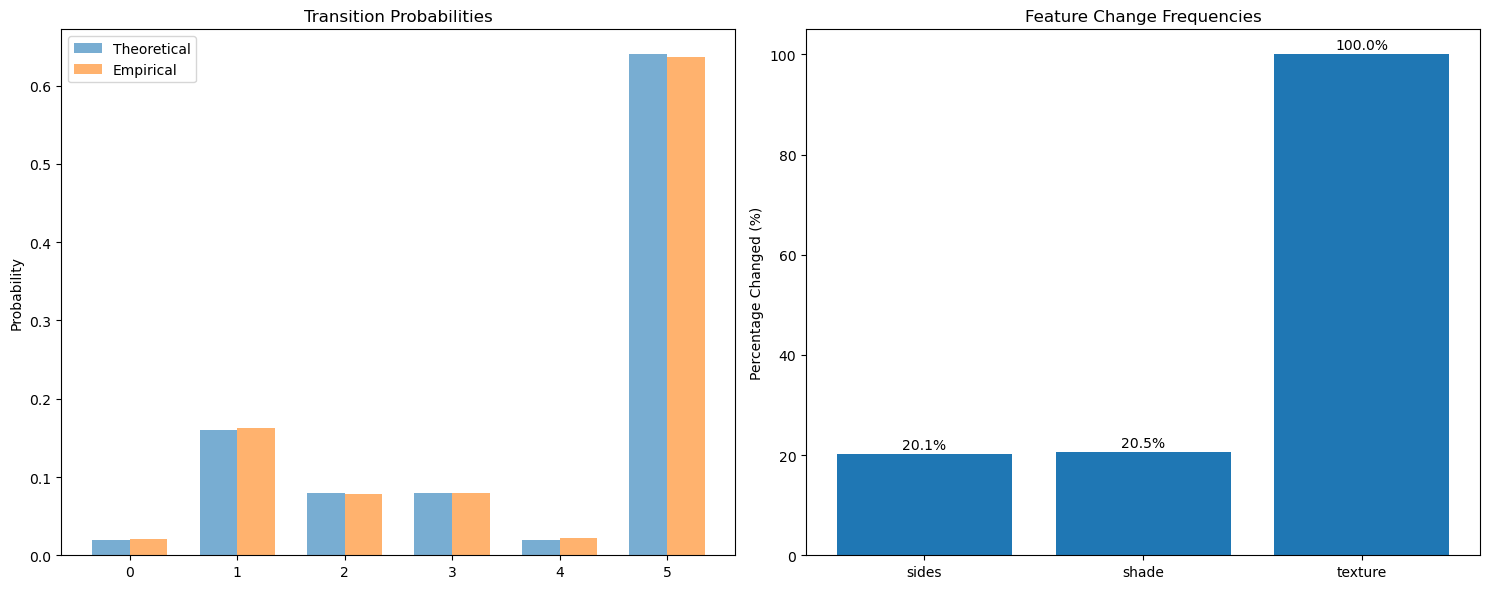


Summary of transitions:
Number of possible next states: 6
Number of observed next states: 6

Feature change frequencies:
Sides: 20.1%
Shade: 20.5%
Texture: 100.0%


In [10]:
test_state = shape_world.get_state_space()[0]

test_action = Action(actor=1, recipient=2)

shape_world.plot_state_transitions(test_state, test_action)


In [11]:
# We can manually test the state transition function
test_state = State(
        shape1=Shape(sides='circle', shade='low', texture='plain'),
        shape2=Shape(sides='square', shade='low', texture='dots'),
        shape3=Shape(sides='triangle', shade='high', texture='dots')
    )

test_action = Action(actor=1, recipient=2) 

# Test state transition
next_state = shape_world.next_state_sample(test_state, test_action)
print(next_state.shape2)


Shape(sides='circle', shade='low', texture='plain')


In [9]:
shape_world.get_possible_next_states(test_state, test_action)

[State(shape1=Shape(sides='circle', shade='low', texture='plain'), shape2=Shape(sides='triangle', shade='high', texture='plain'), shape3=Shape(sides='triangle', shade='high', texture='dots')),
 State(shape1=Shape(sides='circle', shade='low', texture='plain'), shape2=Shape(sides='triangle', shade='low', texture='plain'), shape3=Shape(sides='triangle', shade='high', texture='dots')),
 State(shape1=Shape(sides='circle', shade='low', texture='plain'), shape2=Shape(sides='square', shade='low', texture='plain'), shape3=Shape(sides='triangle', shade='high', texture='dots')),
 State(shape1=Shape(sides='circle', shade='low', texture='plain'), shape2=Shape(sides='circle', shade='low', texture='plain'), shape3=Shape(sides='triangle', shade='high', texture='dots')),
 State(shape1=Shape(sides='circle', shade='low', texture='plain'), shape2=Shape(sides='circle', shade='high', texture='plain'), shape3=Shape(sides='triangle', shade='high', texture='dots')),
 State(shape1=Shape(sides='circle', shade='l

In [13]:
def test_transition_probabilities():
    """Test the transition probability function for different scenarios."""
    
    # Setup
    goal = State(
        shape1=Shape(sides='square', shade='low', texture='plain'),
        shape2=Shape(sides='square', shade='low', texture='plain'),
        shape3=Shape(sides='square', shade='low', texture='plain')
    )
    shape_world = ShapeWorld(goal=goal, discount_rate=0.9)
    
    # Test Case 1: Shape transition (80% same, 20% different)
    test_state = State(
        shape1=Shape(sides='circle', shade='low', texture='plain'),
        shape2=Shape(sides='square', shade='low', texture='plain'),
        shape3=Shape(sides='triangle', shade='high', texture='dots')
    )
    action = Action(actor=1, recipient=2)
    
    # Next state where shape matches actor (80% case)
    next_state_same = State(
        shape1=Shape(sides='circle', shade='low', texture='plain'),  # unchanged
        shape2=Shape(sides='circle', shade='low', texture='stripes'),  # changed to match actor
        shape3=Shape(sides='triangle', shade='high', texture='dots')   # unchanged
    )
    
    prob = shape_world.transition_probability(test_state, action, next_state_same)
    print(f"Test 1a - Shape matches actor (should be 0.8): {prob}")
    
    # Next state where shape is different (20% case)
    next_state_diff = State(
        shape1=Shape(sides='circle', shade='low', texture='plain'),    # unchanged
        shape2=Shape(sides='triangle', shade='low', texture='stripes'), # changed to different shape
        shape3=Shape(sides='triangle', shade='high', texture='dots')    # unchanged
    )
    
    prob = shape_world.transition_probability(test_state, action, next_state_diff)
    print(f"Test 1b - Shape different (should be 0.1): {prob}")
    
    # Test Case 2: Texture cycling
    # Should always cycle plain -> stripes -> dots -> plain
    next_state_wrong_texture = State(
        shape1=Shape(sides='circle', shade='low', texture='plain'),    # unchanged
        shape2=Shape(sides='circle', shade='low', texture='dots'),     # wrong texture cycle
        shape3=Shape(sides='triangle', shade='high', texture='dots')   # unchanged
    )
    
    prob = shape_world.transition_probability(test_state, action, next_state_wrong_texture)
    print(f"Test 2 - Wrong texture cycle (should be 0.0): {prob}")
    
    # Test Case 3: Shade transitions
    # Test 3a: Different shades - move one step toward actor
    test_state_shades = State(
        shape1=Shape(sides='circle', shade='high', texture='plain'),
        shape2=Shape(sides='square', shade='low', texture='plain'),
        shape3=Shape(sides='triangle', shade='high', texture='dots')
    )
    
    next_state_correct_shade = State(
        shape1=Shape(sides='circle', shade='high', texture='plain'),    # unchanged
        shape2=Shape(sides='circle', shade='medium', texture='stripes'), # shade moves toward high
        shape3=Shape(sides='triangle', shade='high', texture='dots')    # unchanged
    )
    
    prob = shape_world.transition_probability(test_state_shades, action, next_state_correct_shade)
    print(f"Test 3a - Correct shade step (should be 0.8): {prob}")
    
    # Test 3b: Same shades - low/high cycling
    test_state_same_shade = State(
        shape1=Shape(sides='circle', shade='low', texture='plain'),
        shape2=Shape(sides='square', shade='low', texture='plain'),
        shape3=Shape(sides='triangle', shade='high', texture='dots')
    )
    
    next_state_shade_cycle = State(
        shape1=Shape(sides='circle', shade='low', texture='plain'),    # unchanged
        shape2=Shape(sides='circle', shade='high', texture='stripes'), # shade cycles to opposite
        shape3=Shape(sides='triangle', shade='high', texture='dots')   # unchanged
    )
    
    prob = shape_world.transition_probability(test_state_same_shade, action, next_state_shade_cycle)
    print(f"Test 3b - Shade cycling (should be 0.16): {prob}")  # 0.8 * 0.2 = 0.16

# Run the tests
test_transition_probabilities()

Test 1a - Shape matches actor (should be 0.8): 0.6400000000000001
Test 1b - Shape different (should be 0.1): 0.07999999999999999
Test 2 - Wrong texture cycle (should be 0.0): 0.0
Test 3a - Correct shade step (should be 0.8): 0.8
Test 3b - Shade cycling (should be 0.16): 0.16000000000000003


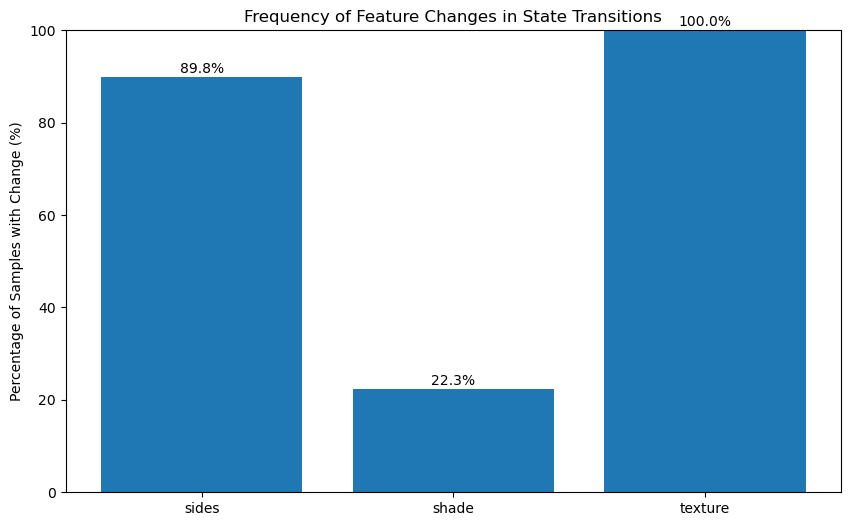


Detailed Results:
Sides: 89.8%
Shade: 22.3%
Texture: 100.0%


In [169]:
def test_feature_changes(shape_world: ShapeWorld, n_samples: int = 1000):
    """
    Run n_samples of state transitions and analyze feature changes.
    
    Returns:
        dict: Counts of different types of feature changes
    """
    # Create a test state and action
    test_state = State(
        shape1=Shape(sides='circle', shade='low', texture='plain'),
        shape2=Shape(sides='square', shade='low', texture='stripes'),
        shape3=Shape(sides='triangle', shade='high', texture='dots')
    )
    test_action = Action(actor=1, recipient=2)  # shape1 acts on shape2
    
    # Track feature changes
    changes = {
        'sides': 0,
        'shade': 0,
        'texture': 0,
        'samples': n_samples
    }
    
    # Run samples
    for _ in range(n_samples):
        next_state = shape_world.next_state_sample(test_state, test_action)
        recipient_old = test_state.shape2
        recipient_new = next_state.shape2
        
        # Count changes
        if recipient_old.sides != recipient_new.sides:
            changes['sides'] += 1
        if recipient_old.shade != recipient_new.shade:
            changes['shade'] += 1
        if recipient_old.texture != recipient_new.texture:
            changes['texture'] += 1
    
    # Convert to percentages
    changes_pct = {
        k: (v / n_samples) * 100 if k != 'samples' else v 
        for k, v in changes.items()
    }
    
    # Plot results
    plt.figure(figsize=(10, 6))
    features = ['sides', 'shade', 'texture']
    percentages = [changes_pct[feature] for feature in features]
    
    plt.bar(features, percentages)
    plt.title('Frequency of Feature Changes in State Transitions')
    plt.ylabel('Percentage of Samples with Change (%)')
    plt.ylim(0, 100)
    
    # Add percentage labels on top of bars
    for i, pct in enumerate(percentages):
        plt.text(i, pct + 1, f'{pct:.1f}%', ha='center')
    
    plt.show()
    
    return changes_pct

# Run the test
goal = State(
    shape1=Shape(sides='square', shade='low', texture='plain'),
    shape2=Shape(sides='square', shade='low', texture='plain'),
    shape3=Shape(sides='square', shade='low', texture='plain')
)
shape_world = ShapeWorld(goal=goal, discount_rate=0.9)
results = test_feature_changes(shape_world)
print("\nDetailed Results:")
for feature, pct in results.items():
    if feature != 'samples':
        print(f"{feature.capitalize()}: {pct:.1f}%")



In [5]:
# Load the value function
with open('goal_value_function.pkl', 'rb') as file:
    value_function = pickle.load(file)

# Create a new dictionary for the modified value function
new_value_function = {}

# Replace texture values in each state and copy the corresponding value
for state, value in value_function.items():
    # Create new shapes with corrected texture values
    new_shapes = []
    for shape in (state.shape1, state.shape2, state.shape3):
        new_texture = 'stripes' if shape.texture == 'present' else 'plain'
        new_shape = Shape(sides=shape.sides, shade=shape.shade, texture=new_texture)
        new_shapes.append(new_shape)
    
    # Create new state with modified shapes
    new_state = State(shape1=new_shapes[0], shape2=new_shapes[1], shape3=new_shapes[2])
    new_value_function[new_state] = value

# Save the modified value function
with open('goal_value_function.pkl', 'wb') as file:
    pickle.dump(new_value_function, file)

# Print some verification info
print(f"Modified {len(value_function)} states")
print("Sample state from new value function:")
sample_state = next(iter(new_value_function))
print(sample_state)

UnpicklingError: NEWOBJ class argument must be a type, not TypeVar

# Optimal Policy

In [11]:
from collections import namedtuple
from typing import TypeVar, Generic, Hashable
import pandas as pd

# Define Shape and State as namedtuples
Shape = namedtuple('Shape', ['sides', 'shade', 'texture'])
State = namedtuple('State', ['shape1', 'shape2', 'shape3'])

# Then define the TypeVars for generic type hints
StateType = TypeVar('StateType', bound=Hashable)
ActionType = TypeVar('ActionType', bound=Hashable)
Likelihood = TypeVar('Likelihood', float, int)

# Now load the value function
with open('goal_value_function.pkl', 'rb') as file:
    value_function = pickle.load(file)

goal_world = GoalWorld()

# Initialize optimal agent
optimal_planner = OptimalGoalPolicy(
    mdp=goal_world,
    value_function=value_function
)

# What are the best goals to set?
log_likelihood_df = optimal_planner.calc_neg_log_likelihood_all_df()
sorted_df = log_likelihood_df.sort_values(by='Negative Log Lik').reset_index(drop=True)

# We can also calc the log lik of specific states
State = TypeVar('State', bound=Hashable)
shape = Shape(sides='square', shade='medium', texture='plain')
state: Tuple[Hashable, Hashable, Hashable] = (shape, shape, shape)
optimal_planner.calc_neg_log_lik(state)

# Show the best choices to make
value_iteration_states_nll = sorted_df
value_iteration_states_nll.to_csv('value_iteration_states_nll.csv', index=False)

In [5]:
# Plot the state space and the corresponding log likelihoods
optimal_planner.plot_state_space_with_likelihood(is_dark=False, save=False, filename=None)


Loading value functions from directory: value-iteration-results


Loading files:  99%|█████████▊| 19430/19683 [10:46<00:02, 103.34it/s] 

# PCFG Policy

In [12]:

class PCFGGoalPolicy(GoalSelectionPolicy[State, Action]):
    '''A policy that uses a probabilistic context-free grammar to generate goals.'''

    def __init__(self, mdp: MarkovDecisionProcess[State, Action], p_rules, cap=100):
        super().__init__(mdp)
        self.NON_TERMINALS = [x[0] for x in p_rules]
        self.PRODUCTIONS = {}
        self.CAP = cap
        self.rules = {}
        for rule in p_rules:
            self.PRODUCTIONS[rule[0]] = rule[1]

    def generate_tree(self, logging=True, tree_str='S', log_prob=0., depth=0):
        '''Use the production rules to generate a possible rule.'''
        current_nt_indices = [tree_str.find(nt) for nt in self.NON_TERMINALS]
        # Sample a non-terminal for generation
        to_gen_idx = sample([idx for idx, el in enumerate(current_nt_indices) if el > -1], 1)[0]
        to_gen_nt = self.NON_TERMINALS[to_gen_idx]
        # Do generation
        leaf = sample(self.PRODUCTIONS[to_gen_nt], 1)[0]
        to_gen_tree_idx = tree_str.find(to_gen_nt)
        tree_str = tree_str[:to_gen_tree_idx] + leaf + tree_str[(to_gen_tree_idx+1):]
        # Update production log prob
        log_prob += log(1/len(self.PRODUCTIONS[to_gen_nt]))
        # Increase depth count
        depth += 1

        # Recursively rewrite string
        if any (nt in tree_str for nt in self.NON_TERMINALS) and depth <= self.CAP:
            return self.generate_tree(logging, tree_str, log_prob, depth)
        elif any (nt in tree_str for nt in self.NON_TERMINALS):
            if logging:
                print('====DEPTH EXCEEDED!====')
            return None
        else:
            if logging:
                print(tree_str, log_prob)
            return tree_str, log_prob
        
    def generate_rules(self, n_iterations=100000) -> pd.DataFrame:
        '''Generate a number of rules.'''
        # reset rules for the object
        self.rules = []

        # generate rules
        for _ in range(n_iterations):
            rule = self.generate_tree(logging=False)
            if rule is not None:
                self.rules.append(rule)

        df = pd.DataFrame(self.rules, columns=['program', 'lp'])

        grouped_df = df.groupby('program')['lp'].mean().reset_index()
        count_df = df['program'].value_counts().reset_index()
        count_df.columns = ['program', 'count']
        result_df = pd.merge(grouped_df, count_df, on='program')
        result_df = result_df.sort_values(by='count', ascending=False).reset_index()
        return result_df

    
    def rule_applies(self, s: State, rule: str) -> bool:
        '''Check if a rule applies to a state.'''
        # TODO: Make a shape wrapper class to evaluate these statements
        
        # turn the rule from a string into a function
        executable_string = "s." + rule
        raise NotImplementedError('Need to implement this function')
        return exec(executable_string) 
    
    def calculate_log_likelihood(self, s: State, rule: str) -> float:
        '''Calculate the log likelihood of a state given a rule.'''

        # check to see if the rule applies to the state
        if self.rule_applies(s, rule):
            rule_likelihood = self.rules[rule]
            return log(rule_likelihood)
        else:
            return 0
    
    def calculate_log_likelihood_all(self) -> float:
        '''Calculate the log likelihood of all states given produced rules.'''
        # check to make sure we have rules
        if len(self.rules) == 0:
            raise ValueError('No rules have been generated yet!')
        
        # iterate through all states and calculate the log likelihood
        log_likelihoods = {}

        # loop through each state and rule
        for state in self.state_space:
            log_likelihood = 0
            # we have to check if the rule applied to the state
            for rule in self.rules:
                # TODO: check to make sure this math is right for log lik
                log_likelihood += rule[1] * self.calculate_log_likelihood(state, rule[0])
            log_likelihoods[state] = log_likelihood

        return log_likelihoods

    def _get_rules(self) -> dict[str, list[str]]:
        return self.rules
    
    def _get_rules_df(self) -> pd.DataFrame:
        # put the rules in a dataframe
        df = pd.DataFrame(self.rules, columns=['program', 'lp'])
        grouped_df = df.groupby('program')['lp'].mean().reset_index()
        count_df = df['program'].value_counts().reset_index()
        count_df.columns = ['program', 'count']
        result_df = pd.merge(grouped_df, count_df, on='program')
        result_df = result_df.sort_values(by='lp', ascending=False).reset_index()
        return result_df

In [13]:
# instantiate the goal space
goal_world_pcfg = GoalWorld()

# the rules of the grammar
productions = [
  ['S', ['and(S,S)', 'A']],
  ['A', ['same(B,C)', 'unique(B,C)']],
  ['B', ['everything', 'D', 'E']],
  ['C', ['true', 'color', 'shape', 'texture', 'false']],
  ['D', ['one', 'G']],
  ['E', ['two', 'H']],
  ['F', ['square', 'circle', 'triangle', 'light', 'medium', 'dark', 'plain', 'stripe']],
  ['G', ['a', 'b', 'c']], # location on the screen
  ['H', ['ab', 'ac', 'bc']],
]

pcfg_policy = PCFGGoalPolicy(mdp=goal_world_pcfg, p_rules=productions, cap=100)

In [14]:
pcfg_ll = pcfg_policy.generate_rules(100000)


# Trying out a new PCFG

In [15]:
# let's try a different grammar
'''
With this grammar, we cover all cases of 1,2, and 3 shapes being compared. 

But importantly, we formalize location and feature symmetry.
Location symmetry arises because the transition function between features is location agnostic.
That is, two(feature) is agnostic to the locations of the features.
Feature symmetry arises because relations between locations are feature agnostic.
That is, same(a,b) can be applied to all features. 
Thus, if people are reusing transition knowledge we might expect them to set goals using location symmetry.
If people are reusing program formulations, we might expect them to set goals using feature symmetry.
'''
productions2 = [
  ['S', ['and(S,S)', 'A']], # allow conjunctions
  ['A', ['one(B)', 'two(B)', 'three(B)', # location symmetry, fix one feature (location agnostic, compare feature)
         'two(E)', 'three(E)', # location symetry, feature symmetry (location agnostic, feature agnostic)
         'two(F,E)', 'three(F,E)', # location symmetry, multiple feature symetry (location agnostic, feature agnostic)
         'one(B,C)', 'two(B,D)', # feature in location, specify feature (location given, feature compare)
         'two(E,D)'# give location, feature symmetry (location given, feature agnostic)
         ]],
  ['B', ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'stripes', 'plain']], # features
  ['C', ['(0)', '(1)', '(2)']], # locations
  ['D', ['(0,1)', '(0,2)', '(1,2)']], # diad locations
  ['E', ['same','unique']], # relation,
  ['F', ['1','2','3']], # number of features to compare
]

# instantiate the goal space
State = namedtuple('State', ['shape1', 'shape2', 'shape3'])
goal_world_pcfg = GoalWorld()
pcfg_policy2 = PCFGGoalPolicy(mdp=goal_world_pcfg, p_rules=productions2, cap=100)
pcfg_ll2 = pcfg_policy2.generate_rules(100000)


# Linking the programs to the state space

In [188]:
def extract_arguments(args_str):
    '''Naive argument extraction assuming balanced parentheses and simple structure'''
    level = 0
    last_split = 0
    args = []
    for i, char in enumerate(args_str):
        if char == '(':
            level += 1
        elif char == ')':
            level -= 1
        elif char == ',' and level == 0:
            args.append(args_str[last_split:i].strip())
            last_split = i + 1
    args.append(args_str[last_split:].strip())  # Add the last argument
    return args

def one(*args, state: State) -> bool:
    '''Check the conditions for one shape in the given state based on arguments.'''

    # One unique feature in the state
    if len(args) == 1 and args[0] in ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'stripes', 'plain']:
        feature = args[0]
        count = 0
        for shape in (state.shape1, state.shape2, state.shape3):
            if (feature in shape.sides or feature in shape.shade or feature in shape.texture):
                count += 1
        return count == 1

    # Feature and location
    elif len(args) == 2 and args[0] in ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'stripes', 'plain'] and args[1] in ['(0)', '(1)', '(2)']:
        feature, location = args
        location = int(location[1])
        shape = (state.shape1, state.shape2, state.shape3)[location]
        return (feature in shape.sides or feature in shape.shade or feature in shape.texture)
    else:
        raise ValueError('Invalid number of arguments for one shape rule.')

def two(*args, state) -> bool:
    '''Check the conditions for two shapes in the given state based on arguments.'''

    # CASE 1 [two(B)]: Two of a feature anywhere
    if len(args) == 1 and args[0] in ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'stripes', 'plain']:
        feature = args[0]
        count = 0
        for shape in (state.shape1, state.shape2, state.shape3):
            if (feature in shape.sides or feature in shape.shade or feature in shape.texture):
                count += 1
        return count == 2
    
    # CASE 2 [two(F,E)]: Compare two shapes for given number of features
    elif (len(args) == 2) and (args[0] in ['1','2', '3']) and args[1] in ['same', 'unique']:
        feature_count, comparison = args
        feature_count = int(feature_count)
        # Check to see if exactly two shapes share the specified number of features, and no more
        if comparison == 'same':
            matching_pairs = 0
            for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 2):
                features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                common_features = len(features1.intersection(features2))
                # Check if the number of common features matches the specified count
                if common_features == feature_count:
                    matching_pairs += 1
            # Return True only if exactly one pair matches the criteria
            return matching_pairs == 1
        # Check over specified number of features, if shapes are unique
        elif comparison == 'unique':
            MAX_NUM_FEATURES = 3
            non_matching_pairs = 0
            for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 2):
                features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                num_unique_features = MAX_NUM_FEATURES - len(features1.intersection(features2))
                # Check if the number of common features exceeds the specified count
                if num_unique_features == feature_count:
                    non_matching_pairs += 1
            # Return True only if exactly one pair matches the criteria
            return non_matching_pairs == 2
            
        else:
            return False

    # CASE 3 [two(E)]: Check to see if any two shapes are the same across all features
    elif len(args) == 1 and args[0] in ['same', 'unique']:
        comparison = args[0]
        feature_count = 3
        # Check to see if exactly two shapes share the specified number of features, and no more
        if comparison == 'same':
            matching_pairs = 0
            for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 2):
                features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                common_features = len(features1.intersection(features2))
                # Check if the number of common features matches the specified count
                if common_features == feature_count:
                    matching_pairs += 1
            # Return True only if exactly one pair matches the criteria
            return matching_pairs == 1
        # Check over specified number of features, if shapes are unique
        elif comparison == 'unique':
            MAX_NUM_FEATURES = 3
            non_matching_pairs = 0
            for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 2):
                features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                num_unique_features = MAX_NUM_FEATURES - len(features1.intersection(features2))
                # Check if the number of common features exceeds the specified count
                if num_unique_features == feature_count:
                    non_matching_pairs += 1
            # Return True only if exactly one pair matches the criteria
            return non_matching_pairs == 2
    
    # CASE 4 [two(B,D)]: Compare two locations for one feature
    elif len(args) == 2 and args[0] in ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'stripes', 'plain'] and args[1] in ['(0,1)', '(0,2)', '(1,2)']:
        feature, location = args
        location1 = int(location[1])
        location2 = int(location[3])
        shape1 = (state.shape1, state.shape2, state.shape3)[location1]
        shape2 = (state.shape1, state.shape2, state.shape3)[location2]
        return (feature in shape1.sides or feature in shape1.shade or feature in shape1.texture) and (feature in shape2.sides or feature in shape2.shade or feature in shape2.texture)

    # CASE 5 [two(D,E)]: Compare two locations across all features
    elif len(args) == 2 and args[0] in ['same','unique'] and args[1] in ['(0,1)', '(0,2)', '(1,2)']:
        comparison, location = args
        location1 = int(location[1])
        location2 = int(location[3])
        shape1 = (state.shape1, state.shape2, state.shape3)[location1]
        shape2 = (state.shape1, state.shape2, state.shape3)[location2]
        features1 = {shape1.sides, shape1.shade, shape1.texture}
        features2 = {shape2.sides, shape2.shade, shape2.texture}
        if comparison == 'same':
            return len(features1.intersection(features2)) == 3
        elif comparison == 'unique':
            return len(features1.intersection(features2)) == 0
        else:
            raise ValueError('Invalid call for the two shapes rule.')

    else:
        raise ValueError('Invalid call for the two shapes rule.')

def three(*args, state: State) -> bool:
    '''Check the conditions for all shapes in the given state based on arguments.'''
    # This function is similar to `one` and `two`, but checks for conditions applying to all three shapes.
    # Since the provided PCFG does not specify a 'three' function directly, we'll assume it's meant to check
    # if all shapes meet a certain condition, which is not directly applicable with the given rules.
    # For demonstration, let's assume it checks if all shapes have a specific feature, though this might not be
    # directly applicable or meaningful with the given PCFG structure and needs to be adjusted based on actual requirements.

    # Feature only (assuming 'three' checks for a feature across all shapes, which is not directly specified)
    if len(args) == 1 and args[0] in ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'stripes', 'plain']:
        feature = args[0]
        return all(feature in shape.sides or feature in shape.shade or feature in shape.texture for shape in (state.shape1, state.shape2, state.shape3))
    
    # Compare three shapes for given number of features
    elif (len(args) == 2) and (args[0] in ['1','2','3']) and args[1] in ['same','unique']:
        feature_count, comparison = args
        feature_count = int(feature_count)
        # Check to see if all three shapes share the specified number of features, and no more
        if comparison == 'same':
            matching_triads = 0
            for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 3):
                features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                features3 = {shape_combo[2].sides, shape_combo[2].shade, shape_combo[2].texture}
                common_features = len(features1.intersection(features2).intersection(features3))
                # Check if the number of common features matches the specified count
                if common_features == feature_count:
                    matching_triads += 1
            # Return True only if exactly one triad matches the criteria
            return matching_triads == 1
        
        # Check over specified number of features, if shapes are unique
        elif comparison == 'unique':
            MAX_NUM_FEATURES = 3
            non_matching_triads = 0
            for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 3):
                features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                features3 = {shape_combo[2].sides, shape_combo[2].shade, shape_combo[2].texture}
                num_unique_features = MAX_NUM_FEATURES - len(features1.intersection(features2).intersection(features3))
                # Check if the number of common features exceeds the specified count
                if num_unique_features == feature_count:
                    non_matching_triads += 1
            # Return True only if exactly one triad matches the criteria
            return non_matching_triads == 1

    # TODO: Check logic here
    elif len(args) == 1 and args[0] in ['same', 'unique']:
        feature = args[0]
        features = [shape.sides for shape in (state.shape1, state.shape2, state.shape3)]
        features += [shape.shade for shape in (state.shape1, state.shape2, state.shape3)]
        features += [shape.texture for shape in (state.shape1, state.shape2, state.shape3)]
        unique_features = set(features)
        if feature == 'same':
            return len(unique_features) == 3
        elif feature == 'unique':
            return len(features) == len(unique_features)
        
    # TODO: Add case for checking multiple features

    else:
        raise ValueError('Invalid number of arguments for three shapes rule.')

def rule_applies(program: str, s: State) -> bool:
    print(program)
    # recursively unpack nested and statements
    if program.startswith('and'):
        args = extract_arguments(program[4:-1])
        print(f'All arguments: {args}')
        outcome1 = rule_applies(args[0],s)
        outcome2 = rule_applies(args[1],s)
        return outcome1 and outcome2  #all(rule_applies(arg, s) for arg in args)
    
    # once the and statements are unpacked, we can evaluate the rules
    elif program.startswith(('one', 'two', 'three')):
        func_name, args_str = program.split('(', 1)
        args = extract_arguments(args_str[:-1])  # Remove the closing parenthesis and extract arguments
        func = globals()[func_name]  # Dynamically get the function based on its name
        print(f"Calling function: {func_name} with args: {args} and state: {state}")
        # Call the function with unpacked arguments and the state
        return func(*args, state=s)
    

# Tests